In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.Chem import AllChem as Chem

# SMARTS

In [24]:
df = pd.read_csv('VEGF2.csv')
df = df.drop(['tid', 'standard_type', 'confidence_score', 'cmpd_pref_name', 'activity_comment'], axis=1)
df['mol'] = [Chem.MolFromSmiles(i) for i in df['canonical_smiles']]
df.head()

,cmpd_chembl_id,canonical_smiles,value,mol
0,CHEMBL356626,CCCOCc1ccc2c(c1)c3c4CNC(=O)c4c5c(Cc6ccccc56)c3...,7.890,<rdkit.Chem.rdchem.Mol object at 0x000001DFF5E...
1,CHEMBL171558,COc1cc2c(Nc3cccc4occc34)ncnc2cc1OCCCN5CCOCC5,6.600,<rdkit.Chem.rdchem.Mol object at 0x000001DFFFF...
2,CHEMBL221053,CCc1cccc(NC(=O)Nc2ccc(cc2)c3cccc4[nH]nc(N)c34)c1,8.220,<rdkit.Chem.rdchem.Mol object at 0x000001DFFFF...
3,CHEMBL3754450,COc1cccc(c1)C(=O)CN2CCN(CC2)c3nnc(c4ccccc4)c5c...,5.470,<rdkit.Chem.rdchem.Mol object at 0x000001DF823...
4,CHEMBL383255,Cn1cnc(NCc2ccncc2)c1c3oc(Nc4ccc(OC(F)(F)F)cc4)nn3,7.105,<rdkit.Chem.rdchem.Mol object at 0x000001DF823...


In [25]:
len(df.index)

6715

In [26]:
s = Chem.MolFromSmarts('aa') # c1ccccc1c2ccccc2
s2 = Chem.MolFromSmarts('aAa') # c1ccccc1/C\c2ccccc2
s3 = Chem.MolFromSmarts('aAAa') # c1ccccc1/C-C\c2ccccc2

In [27]:
struct = [mol.HasSubstructMatch(s) for mol in df['mol']]
struct2 = [mol.HasSubstructMatch(s2) for mol in df['mol']]
struct3 = [mol.HasSubstructMatch(s3) for mol in df['mol']]

In [28]:
#df["struct"] = struct
#df["struct"].value_counts() 

In [29]:
count = np.sum(struct)
count2 = np.sum(struct2)
count3 = np.sum(struct3)
count, count2, count3

(6711, 3940, 1565)

# Similarity search

In [30]:
def similarity_search(df, f): 
    sim = [DataStructs.FingerprintSimilarity(x, f) for x in df.finger]
    return sim

In [31]:
def similarity_search_treshold(df, f, treshold): 
    sim = similarity_search(df, f)
    l = []
    for s in sim:
        if s > treshold:
            l.append(1)
        else:
            l.append(0)
    return l

In [32]:
finger = [Chem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in df.mol] #do vzdálenosti 2
df['finger'] = finger

In [33]:
treshold = 7.523
df['activity']='inactive'
df.loc[df['value'] > treshold, 'activity'] = 'active'
df['activity'].value_counts()

inactive    4743
active      1972
Name: activity, dtype: int64

In [34]:
d = df.loc[df.activity == 'active']
d.index

Int64Index([   0,    2,    7,   21,   22,   23,   26,   30,   31,   32,
            ...
            6699, 6700, 6701, 6702, 6703, 6704, 6705, 6706, 6707, 6709],
           dtype='int64', length=1972)

In [35]:
f = Chem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(df.canonical_smiles[6709]), 2, nBits=1024)

In [36]:
res = similarity_search(df, f)
df['similar'] = res

In [37]:
#r = similarity_search_treshold(df, f, 0.5)
#np.sum(r)
df['similarity']='NO'
df.loc[df['similar'] > 0.80, 'similarity'] = 'YES'
df['similarity'].value_counts()

NO     6711
YES       4
Name: similarity, dtype: int64

<AxesSubplot:xlabel='similar', ylabel='Count'>

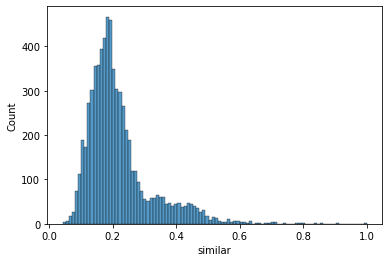

In [38]:
sns.histplot(df.similar)

In [62]:
df_hit = df.loc[df.similarity == 'YES']
df_hit

,cmpd_chembl_id,canonical_smiles,value,mol,finger,activity,similar,similarity
1661,CHEMBL3962233,COc1cc2c(Nc3ccc(NC(=O)Nc4ccc(Cl)cc4)c(Cl)c3)nc...,6.55,<rdkit.Chem.rdchem.Mol object at 0x000001DF822...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",inactive,0.902778,YES
6133,CHEMBL3968039,COc1cc2c(Nc3ccc(NC(=O)Nc4ccc(C)c(C)c4)c(Cl)c3)...,7.10,<rdkit.Chem.rdchem.Mol object at 0x000001DF822...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",inactive,0.853333,YES
6171,CHEMBL3979264,COc1cc2c(Nc3ccc(NC(=O)Nc4ccccc4)c(Cl)c3)ncnc2c...,6.58,<rdkit.Chem.rdchem.Mol object at 0x000001DF822...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",inactive,0.840000,YES
6709,CHEMBL3929448,COc1cc2c(Nc3ccc(NC(=O)Nc4ccc(F)c(Cl)c4)c(Cl)c3...,7.85,<rdkit.Chem.rdchem.Mol object at 0x000001DF822...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",active,1.000000,YES


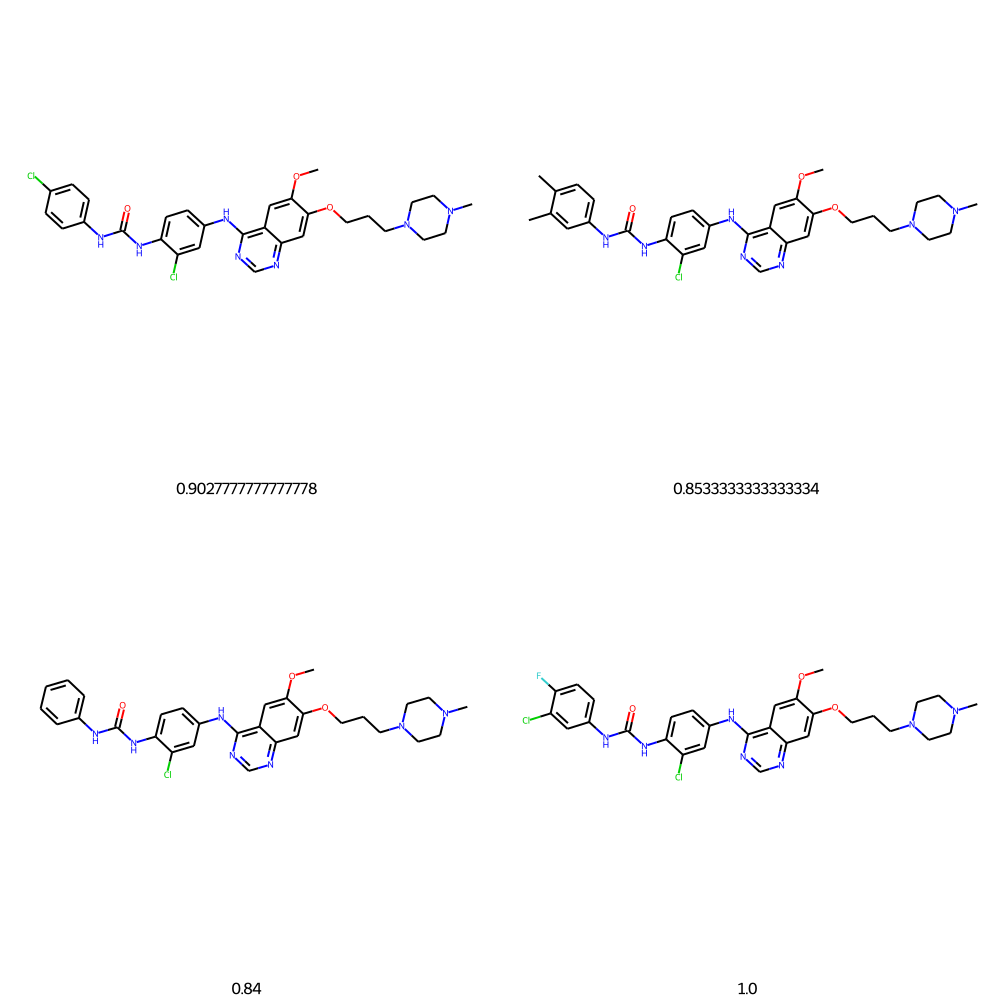

In [85]:
index = df_hit.index
Draw.MolsToGridImage([df.mol[index[i]] for i in range(0,len(df_hit))], molsPerRow=2, subImgSize=(500,500),
                     legends=["{}".format(sim) for sim in df_hit.similar])

In [46]:
def similarity(df):
    a = []
    for i in range(0,len(df.index)):
        s = similarity_search(df, df.finger[i])
        a.append(s)
    return a

In [47]:
distance_matrix = similarity(df)

In [56]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [57]:
distance_matrix_flatten = flatten(distance_matrix)

In [86]:
sum(distance_matrix_flatten)/len(distance_matrix_flatten)

0.15876241248264922

In [53]:
#sum(distance_matrix[0])
suma = sum(sum(distance_matrix,[]))  
length = len(distance_matrix[0])*len(distance_matrix)
suma/length

0.15876241248264922

<AxesSubplot:ylabel='Count'>

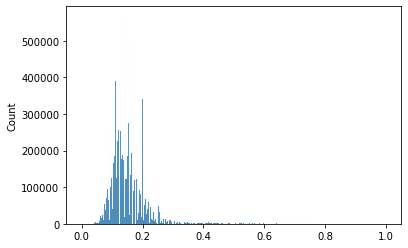

In [88]:
sns.histplot(distance_matrix_flatten)

C:\Users\domiz\Miniconda3\envs\my-rdkit-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

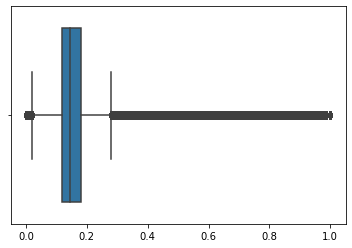

In [90]:
sns.boxplot(distance_matrix_flatten)